## Data

The dataset is available in 5x5x5µm section taken from the CA1 hippocampus region of the brain, corresponding to a 1065x2048x1536 volume. The resolution of each voxel is approximately 5x5x5nm. The data is provided as multipage TIF files

### Acknowledgement

https://www.epfl.ch/labs/cvlab/data/data-em/

### Data Preprocessing for Training

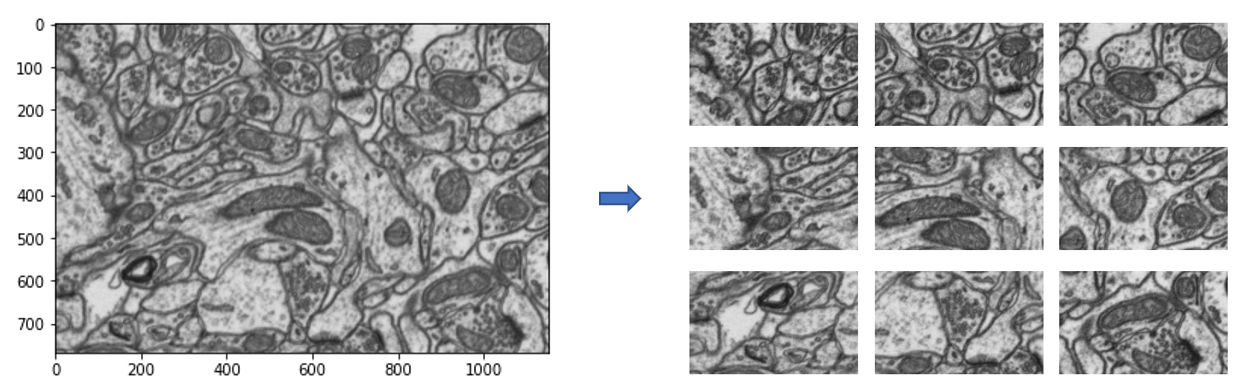

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from keras.utils import normalize
import tifffile as tifffile
from models import Unet
from PIL import Image
from patchify import patchify, unpatchify
from keras.models import load_model

model = load_model("./mitochondria_unet.hdf5", compile=False)

In [2]:
test_img=tifffile.imread('./Electron Microscopy Dataset/testing.tif')
test_mask=tifffile.imread('./Electron Microscopy Dataset/testing_groundtruth.tif')

img = test_img[0]
r_img = Image.fromarray(img)
r_img = np.array(r_img.resize((1152,768)))

mask=test_mask[0]/255.
r_mask = Image.fromarray(mask)
r_mask = np.array(r_mask.resize((1152,768)))

patches = patchify(r_img, (256,384), step=128)

In [3]:
predicted_patches = []
for i in range(patches.shape[0]):
    for j in range(patches.shape[1]):
        
        P_img = patches[i,j,:,:]
        P_img_norm = np.expand_dims(normalize(np.array(P_img), axis=1),2)
        P_img_input=np.expand_dims(P_img_norm, 0)

        P_img_prediction = (model.predict(P_img_input)[0,:,:,0] > 0.5).astype(np.uint8)
        predicted_patches.append(P_img_prediction)

predicted_patches = np.array(predicted_patches)
predicted_patches_reshaped = np.reshape(predicted_patches, (patches.shape[0], patches.shape[1], 256,384))
reconstructed_image = unpatchify(predicted_patches_reshaped, r_img.shape)

IoU Score: 0.9285475332890962


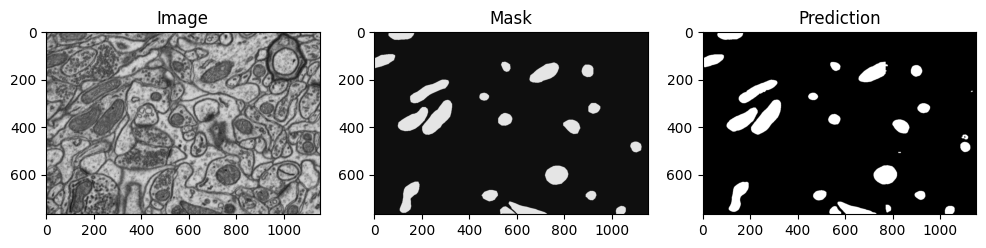

In [4]:
plt.figure(figsize=(12,8))
plt.subplot(131)
plt.imshow(r_img,cmap='gray')
plt.title('Image')
plt.subplot(132)
plt.imshow(r_mask,cmap='gray')
plt.title('Mask')
plt.subplot(133)
plt.imshow(reconstructed_image,cmap='gray')
plt.title('Prediction')

Int = np.logical_and(r_mask, reconstructed_image)
iou = np.sum(Int) / ((np.sum(r_mask)+np.sum(reconstructed_image))- np.sum(Int))
print('IoU Score: %s' % iou)